In [1]:
%pylab inline

from __future__ import division 

import copy
import numpy as np

# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 1.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 1.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 1.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 1.5
rc('axes', linewidth=2)

from matplotlib.patches import Ellipse

from astropy.io import fits 
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.wcs import WCS

import cubehelix  # Cubehelix color scheme from https://github.com/jradavenport/cubehelix

cmap1 = cubehelix.cmap(start=0.5, rot=-0.8, gamma=1.0, 
                       minSat=1.2, maxSat=1.2, 
                       minLight=0.0, maxLight=1.0)
cmap2 = cubehelix.cmap(start=2.0, rot=-1.0, gamma=2.5, 
                       minSat=1.2, maxSat=1.2, 
                       minLight=0.0, maxLight=1.0, reverse=True)
cmap3 = cubehelix.cmap(start=0.5, rot=-0.8, gamma=1.2, 
                       minSat=1.2, maxSat=1.2, 
                       minLight=0.0, maxLight=1.0)
cmap4 = cubehelix.cmap(start=0.5, rot=-0.8, gamma=0.7, 
                       minSat=1.2, maxSat=1.2, 
                       minLight=0.0, maxLight=1.0)

from palettable.colorbrewer.sequential import Greys_3 as pcmap1
cmap5 = pcmap1.mpl_colormap

from palettable.colorbrewer.diverging  import RdYlGn_11 as pcmap2
cmap6 = pcmap2.mpl_colormap

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def zscale(img, contrast=0.25, samples=500):

    # Image scaling function form http://hsca.ipmu.jp/hscsphinx/scripts/psfMosaic.html
    ravel = img.ravel()
    if len(ravel) > samples:
        imsort = np.sort(np.random.choice(ravel, size=samples))
    else:
        imsort = np.sort(ravel)

    n = len(imsort)
    idx = np.arange(n)

    med = imsort[n/2]
    w = 0.25
    i_lo, i_hi = int((0.5-w)*n), int((0.5+w)*n)
    p = np.polyfit(idx[i_lo:i_hi], imsort[i_lo:i_hi], 1)
    slope, intercept = p

    z1 = med - (slope/contrast)*(n/2-n*w)
    z2 = med + (slope/contrast)*(n/2-n*w)

    return z1, z2

In [3]:
def srcToRaDec(src):
    """
    Return a list of (RA, DEC)
    """
    
    raArr  = np.asarray([coord[0] * 180.0 / np.pi for coord in src['coord']])
    decArr = np.asarray([coord[1] * 180.0 / np.pi for coord in src['coord']])

    return raArr, decArr

In [4]:
def toColorArr(data, bottom=None, top=None):
    """
    Convert a data array to "color array" (between 0 and 1)
    """
    if top is not None:
        data[data >= top]    = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))) * 255.0

In [5]:
def getEll2Plot(x, y, re, ell, theta): 
    
    a = (re * 2.0)
    b = (re * (1.0 - ell) * 2.0)
    pa = (theta + 90.0)
    
    ells = [Ellipse(xy=np.array([x[i], y[i]]), 
                    width=np.array(b[i]), 
                    height=np.array(a[i]), 
                    angle=np.array(pa[i])) 
            for i in range(x.shape[0])]
    
    return ells

In [6]:
def srcMoments2Ellip(ellip):
    """
    Translate The 2nd Moments into Elliptical Shape
    """
    
    Ixx, Iyy, Ixy = ellip[:,0], ellip[:,1], ellip[:,2]
    
    e1 = (Ixx - Iyy) / (Ixx + Iyy) 
    e2 = (2.0 * Ixy / (Ixx + Iyy))
    ell = np.sqrt(e1 ** 2.0 + e2 ** 2.0) 
    
    theta = (0.5 * np.arctan2(e2, e1)) * 180.0 / np.pi
    r2 = np.sqrt(Ixx + Iyy)
    
    return r2, ell, theta

# Test Data

In [42]:
redID = '127'
#redID = '10134'

filter01 = 'I'

loc = redID + '/HSC-' + filter01 + '/'

imgFile = loc + 'redBCG_' + redID + '_HSC-' + filter01 + '_full_img.fits'
catFile = 'redBCG_' + redID + '_HSC-' + filter01 + '_full_meas.fits'

refFile = 'redBCG_' + redID + '_HSC-' + filter01 + '_full_ref.fits'

imgData = fits.open(imgFile)[0].data
imgHead = fits.open(imgFile)[0].header
catData = fits.open(catFile)[1].data
refData = fits.open(refFile)[1].data

In [33]:
catData.columns

ColDefs(
    name = 'flags'; format = '115X'
    name = 'id'; format = '1K'
    name = 'coord'; format = '2D'; unit = 'IRCS; radians'
    name = 'parent'; format = '1K'
    name = 'deblend_nchild'; format = '1J'
    name = 'deblend_psf-center'; format = '2D'
    name = 'deblend_psf-flux'; format = '1D'
    name = 'deblend_blendedness'; format = '1D'
    name = 'centroid_sdss'; format = '2D'; unit = 'pixels'
    name = 'centroid_sdss_err'; format = '3E'; unit = 'pixels^2'
    name = 'centroid_naive'; format = '2D'; unit = 'pixels'
    name = 'centroid_naive_err'; format = '3E'; unit = 'pixels^2'
    name = 'shape_hsm_moments'; format = '3D'; unit = 'pixels^2'
    name = 'shape_hsm_moments_err'; format = '6E'; unit = 'pixels^4'
    name = 'shape_hsm_moments_centroid'; format = '2D'; unit = 'pixels'
    name = 'shape_hsm_moments_centroid_err'; format = '3E'; unit = 'pixels^2'
    name = 'shape_hsm_psfMoments'; format = '3D'; unit = 'pixels^2'
    name = 'shape_hsm_psfMoments_err'; format 

In [34]:
print "Number of detections (with redundent ones) : %6d" % len(catData)
catUse = catData[(catData['deblend_nchild'] == 0)]
print "Number of deblended detections : %6d" % len(catUse)

Number of detections (with redundent ones) :   5740
Number of deblended detections :   5177


In [35]:
catCModel1 = catData[(np.isfinite(catData['cmodel_flux'])) &
                    (np.isfinite(catData['cmodel_exp_flux'])) &
                    (np.isfinite(catData['cmodel_dev_flux'])) &
                    (catData['deblend_nchild'] == 0) & 
                    (catData['classification_extendedness'] >= 0.5) &
                    (catData['cmodel_flux']/catData['cmodel_flux_err'] >= 5.0)]
print len(catCModel1)

2803


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal


In [36]:
catCModel = catData[(np.isfinite(catData['cmodel_flux'])) &
                     (np.isfinite(catData['cmodel_exp_flux'])) &
                     (np.isfinite(catData['cmodel_dev_flux'])) &
                     (np.isfinite(catData['flux_kron'])) &
                     (catData['deblend_nchild'] == 0) & 
                     (catData['classification_extendedness'] >= 0.8) &
                     (catData['cmodel_flux']/catData['cmodel_flux_err'] >= 6.0)]
print len(catCModel)

2476


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater_equal


## Get the (RA, DEC) of all the detections 

In [37]:
raUse, decUse = srcToRaDec(catUse)

# Convert the (RA, DEC) into (X, Y)
w = WCS(imgHead)
xyUse = w.wcs_world2pix((catUse['coord'] * 180.0 / np.pi), 1)
xUse, yUse = xyUse[:,0], xyUse[:,1]

In [38]:
raCmod, decCmod = srcToRaDec(catCModel)

# Convert the (RA, DEC) into (X, Y)
xyCmod = w.wcs_world2pix((catCModel['coord'] * 180.0 / np.pi), 1)
xCmod, yCmod = xyCmod[:,0], xyCmod[:,1]

## Get the Ellipse Shapes for the cModels 

In [39]:
expEllipse  = catCModel['cmodel_exp_ellipse']
devEllipse  = catCModel['cmodel_dev_ellipse']
sdssEllipse = catCModel['shape_sdss']

rKron = catCModel['flux_kron_radius']

cmodMag = -2.5 * np.log10(catCModel['cmodel_flux']) + 27.0
expMag = -2.5 * np.log10(catCModel['cmodel_exp_flux']) + 27.0
devMag = -2.5 * np.log10(catCModel['cmodel_dev_flux']) + 27.0

print np.nanmin(cmodMag), np.nanmax(cmodMag)
print np.nanmin(expMag), np.nanmax(expMag)
print np.nanmin(devMag), np.nanmax(devMag)

cmodColor = toColorArr(cmodMag, top=24.5, bottom=18.0)
print np.nanmin(cmodColor), np.nanmax(cmodColor)

16.4748820217 29.1604570718
17.0674202315 29.3862956951
16.3371356177 29.4955735564
0.0 255.0


In [40]:
rExp, eExp, paExp = srcMoments2Ellip(expEllipse)
ellipseExp = getEll2Plot(xCmod, yCmod, rExp, eExp, paExp)

rDev, eDev, paDev = srcMoments2Ellip(devEllipse)
ellipseDev = getEll2Plot(xCmod, yCmod, rDev, eDev, paDev)

rSdss, eSdss, paSdss = srcMoments2Ellip(sdssEllipse)
ellipseSdss = getEll2Plot(xCmod, yCmod, rSdss, eSdss, paSdss)

ellipseKron = getEll2Plot(xCmod, yCmod, rKron, eSdss, paSdss)

# Show The Image

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1500)

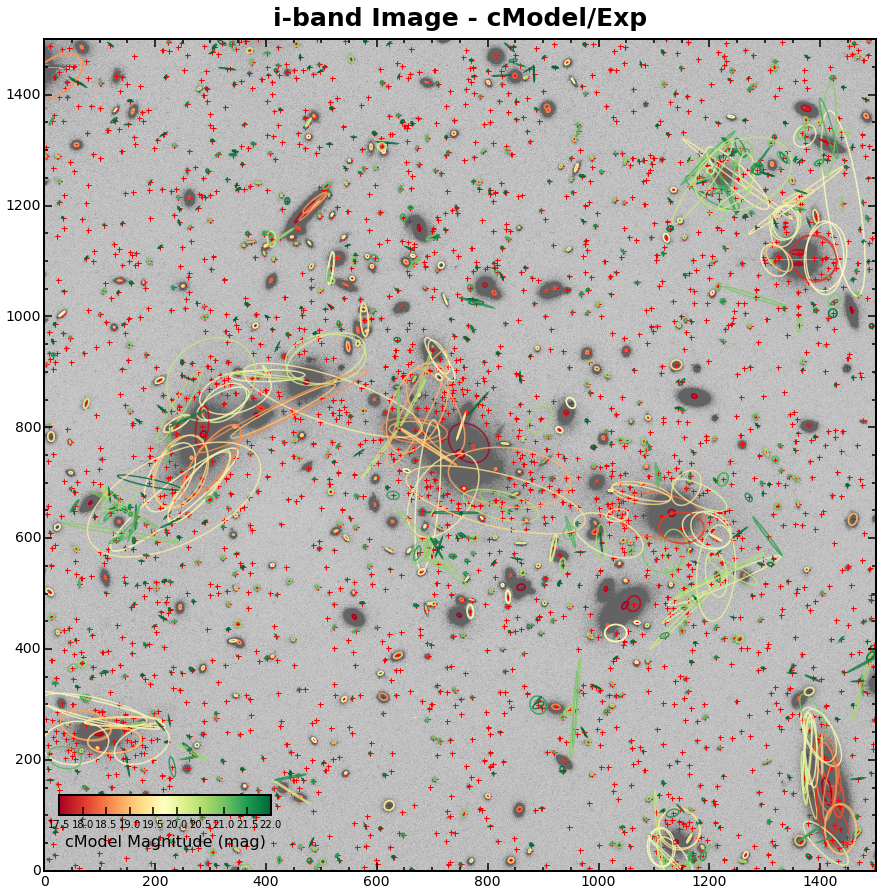

In [41]:
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
ax.set_title('i-band Image - cModel/Exp', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

imin, imax = zscale(imgData, contrast=0.10, samples=500)

ax.imshow(np.arcsinh(imgData), interpolation="none", 
           vmin=imin, vmax=imax, 
           cmap=cmap5)

ax.scatter(xUse, yUse, marker='+', s=25, c='r')
#ax.scatter(xCmod, yCmod, marker='o', s=30, c='k', facecolor='none')

for (e, c) in zip(ellipseExp, cmodColor):
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.8)
    e.set_edgecolor(cmap6(int(c)))
    e.set_facecolor('none')
    e.set_linewidth(1.5)
    
cax = fig.add_axes([0.14, 0.18, 0.21, 0.02])
norm = mpl.colors.Normalize(vmin=17.5, vmax=22.0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap6,
                                 norm=norm,
                                 orientation='horizontal')
cbar.set_label('cModel Magnitude (mag)', fontsize=16)

ax.set_xlim(0, imgData.shape[1]-1)
ax.set_ylim(0, imgData.shape[0]-1)

#fig.tight_layout()

In [21]:
imgData.shape

(1501, 1501)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1500)

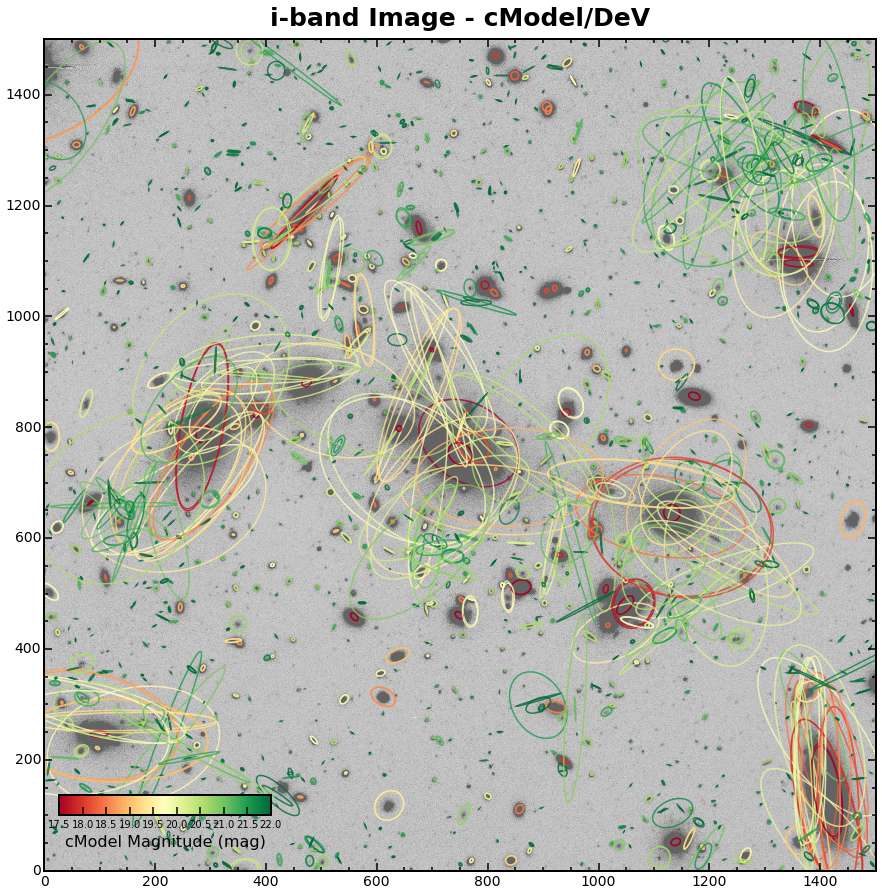

In [25]:
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
ax.set_title('i-band Image - cModel/DeV', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

imin, imax = zscale(imgData, contrast=0.10, samples=500)

ax.imshow(np.arcsinh(imgData), interpolation="none", 
           vmin=imin, vmax=imax, 
           cmap=cmap5)

#ax.scatter(xUse, yUse, marker='+', s=30, c='r')
#ax.scatter(xCmod, yCmod, marker='o', s=30, c='k', facecolor='none')

for (e, c) in zip(ellipseDev, cmodColor):
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.8)
    e.set_edgecolor(cmap6(int(c)))
    e.set_facecolor('none')
    e.set_linewidth(1.5)
    
cax = fig.add_axes([0.14, 0.18, 0.21, 0.02])
norm = mpl.colors.Normalize(vmin=17.5, vmax=22.0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap6,
                                 norm=norm,
                                 orientation='horizontal')
cbar.set_label('cModel Magnitude (mag)', fontsize=16)

ax.set_xlim(0, imgData.shape[1]-1)
ax.set_ylim(0, imgData.shape[0]-1)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


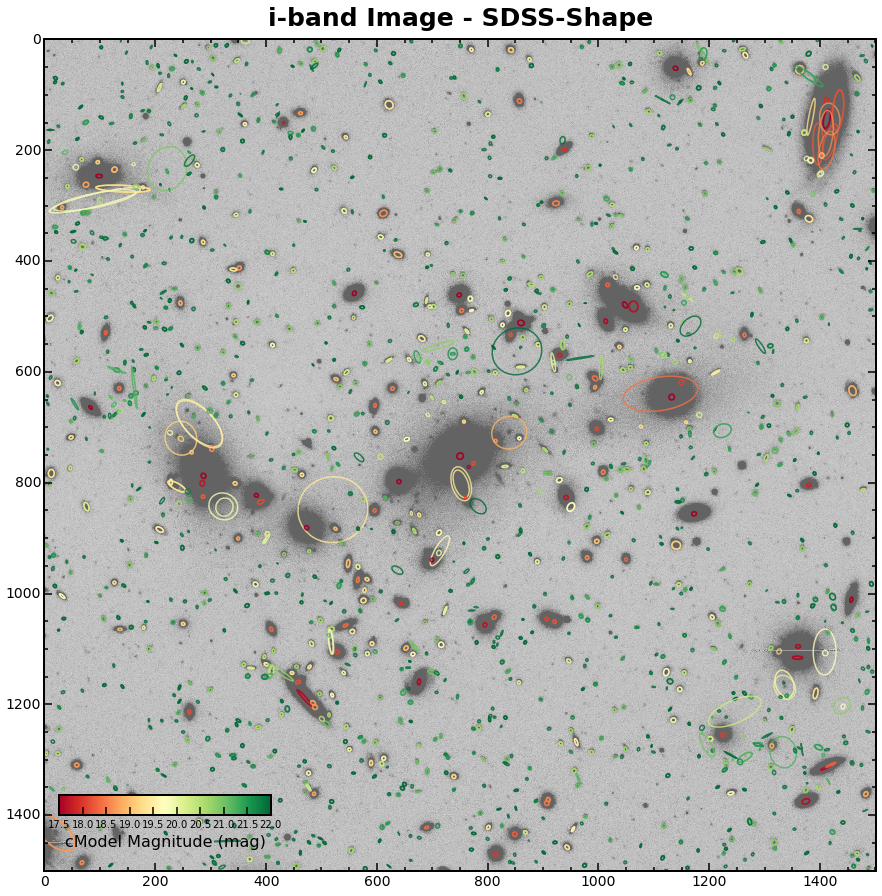

In [26]:
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
ax.set_title('i-band Image - SDSS-Shape', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

imin, imax = zscale(imgData, contrast=0.10, samples=500)

ax.imshow(np.arcsinh(imgData), interpolation="none", 
           vmin=imin, vmax=imax, 
           cmap=cmap5)

#ax.scatter(xUse, yUse, marker='+', s=30, c='r')
#ax.scatter(xCmod, yCmod, marker='o', s=30, c='k', facecolor='none')

for (e, c) in zip(ellipseSdss, cmodColor):
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.8)
    e.set_edgecolor(cmap6(int(c)))
    e.set_facecolor('none')
    e.set_linewidth(1.5)
    
cax = fig.add_axes([0.14, 0.18, 0.21, 0.02])
norm = mpl.colors.Normalize(vmin=17.5, vmax=22.0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap6,
                                 norm=norm,
                                 orientation='horizontal')
cbar.set_label('cModel Magnitude (mag)', fontsize=16)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


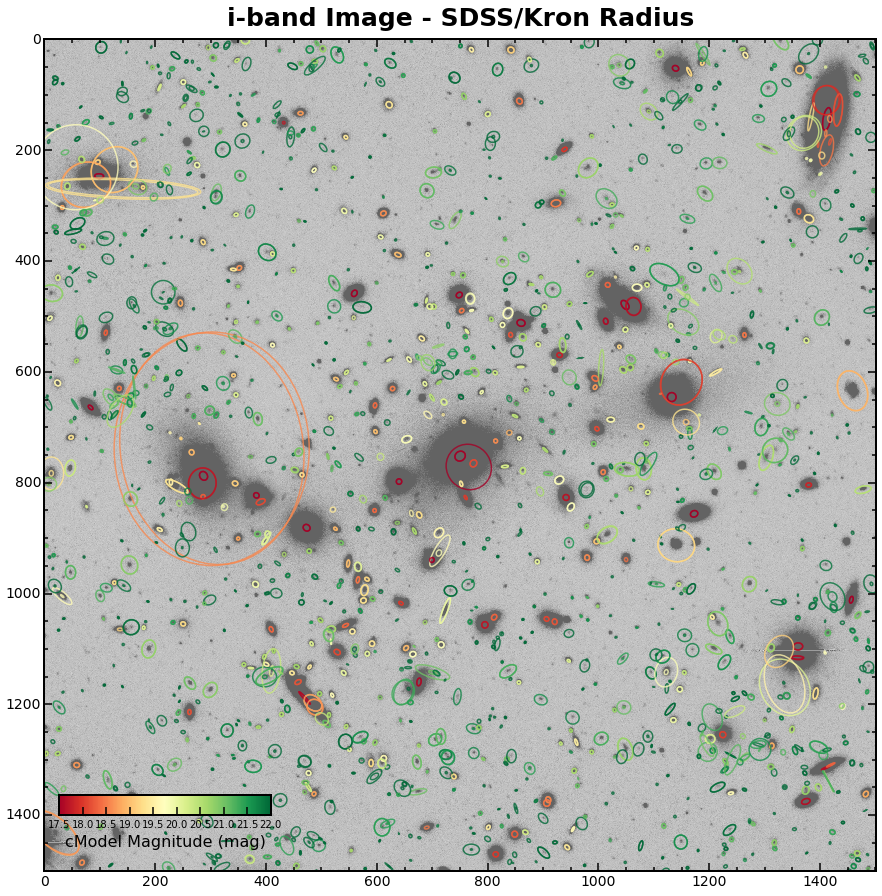

In [27]:
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
ax.set_title('i-band Image - SDSS/Kron Radius', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

imin, imax = zscale(imgData, contrast=0.10, samples=500)

ax.imshow(np.arcsinh(imgData), interpolation="none", 
           vmin=imin, vmax=imax, 
           cmap=cmap5)

#ax.scatter(xUse, yUse, marker='+', s=30, c='r')
#ax.scatter(xCmod, yCmod, marker='o', s=30, c='k', facecolor='none')

for (e, c) in zip(ellipseKron, cmodColor):
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.8)
    e.set_edgecolor(cmap6(int(c)))
    e.set_facecolor('none')
    e.set_linewidth(1.5)
    
cax = fig.add_axes([0.14, 0.18, 0.21, 0.02])
norm = mpl.colors.Normalize(vmin=17.5, vmax=22.0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap6,
                                 norm=norm,
                                 orientation='horizontal')
cbar.set_label('cModel Magnitude (mag)', fontsize=16)

In [29]:
refData.columns

ColDefs(
    name = 'flags'; format = '115X'
    name = 'id'; format = '1K'
    name = 'coord'; format = '2D'; unit = 'IRCS; radians'
    name = 'parent'; format = '1K'
    name = 'deblend_nchild'; format = '1J'
    name = 'deblend_psf-center'; format = '2D'
    name = 'deblend_psf-flux'; format = '1D'
    name = 'deblend_blendedness'; format = '1D'
    name = 'centroid_sdss'; format = '2D'; unit = 'pixels'
    name = 'centroid_sdss_err'; format = '3E'; unit = 'pixels^2'
    name = 'centroid_naive'; format = '2D'; unit = 'pixels'
    name = 'centroid_naive_err'; format = '3E'; unit = 'pixels^2'
    name = 'shape_hsm_moments'; format = '3D'; unit = 'pixels^2'
    name = 'shape_hsm_moments_err'; format = '6E'; unit = 'pixels^4'
    name = 'shape_hsm_moments_centroid'; format = '2D'; unit = 'pixels'
    name = 'shape_hsm_moments_centroid_err'; format = '3E'; unit = 'pixels^2'
    name = 'shape_hsm_psfMoments'; format = '3D'; unit = 'pixels^2'
    name = 'shape_hsm_psfMoments_err'; format 

In [31]:
refData[0]['flags']

array([False,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False], dtype=bool)